# Consulta Alvo da Investigação 

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType
from graphframes import *

In [2]:
# Nomes de aquivos e pastas
parquet_dir_name = 'output/embeddings_nome'
parquet_nodes  = 'dataset/grapho/nodes'
parquet_edges = 'dataset/grapho/edges'
# cnpj_alvo='27364903' # Eco em pets
# cnpj_alvo='20848420' # Saritur # https://shorturl.at/tEMO7
#cnpj_alvo='15464658' # Sta Terezinha Atacadista # https://shorturl.at/koqz4
# cnpj_alvo='07738069' # Super adega
cnpj_alvo='11059149' # Cincol 19322044

## Inicia Seção do Spark

In [33]:
spark = SparkSession.builder \
            .appName("consulta_arvore") \
            .getOrCreate()

### Realizar a leitura Nodes (Pjs e Pfs) e Edges (relacionamentos) e monta grafo

In [34]:
# Carrega nodes
nodes = spark.read.parquet(parquet_nodes)

24/08/26 16:49:15 WARN CacheManager: Asked to cache already cached data.


DataFrame[id: string, te_dados_em: struct<porteEmpresa:string,capitalSocial:string,cpfResponsavel:string,nomeEmpresarial:string,naturezaJuridica:string,qualificacaoResponsavel:string>, id_estabelecimento: string, te_dados_es: struct<uf:string,cep:string,ddd1:string,ddd2:string,pais:string,email:string,bairro:string,numero:string,municipio:string,telefone1:string,telefone2:string,cnaeFiscal:string,logradouro:string,complemento:string,dataCadastro:string,nomeFantasia:string,cidadeExterior:string,tipoLogradouro:string,cnaesSecundarias:string,situacaoEspecial:string,situacaoCadastral:string,dataSituacaoEspecial:string,dataSituacaoCadastral:string,motivoSituacaoCadastral:string,identificadorMatrizFilial:string>, id_tipoPessoa: int]

In [35]:
# Carrega edges
edges = spark.read.parquet(parquet_edges)

24/08/26 16:49:19 WARN CacheManager: Asked to cache already cached data.


DataFrame[src: string, dst: string, te_dados_sc: struct<pais:string,entradaSociedade:string,socioEstrangeiro:string,qualificacaoSocio:string,identificadorSocio:string,cpfRepresentanteLegal:string,qualificacaoRepresentanteLegal:string>]

In [36]:
# Carrega embeddings


DataFrame[id: string, nomeFantasia: string, embeddings: array<float>]

In [38]:
# Criando o grafo de relacionamento empresas->socios
g = GraphFrame(nodes, edges)

## Começa investigação do CNPJ alvo
O fluxosegue nessa ordem:
1. Consulta sócios do CNPJ alvo para formar a lista de Sócios Alvo, junto consulta-se o nome fantasia.
2. Consula dos CEP do dos Sócios Alvo
4. __Montas-se o Cluster de empresas pelo CEP__ - Leitura dos vetores do embedding dos nomes fantasias do universo de empresas a serem pesquisadas.

In [39]:
# Consulta todos sócios do alvo
id = cnpj_alvo

pFind  = "(a)-[e]->(b)"
socios_target = g.find(pFind) \
          .filter(f"(a.id = '{id}') OR (b.id = '{id}')") \
          .select(col("a.id").alias("src"), col("a.te_dados_es.nomeFantasia").alias("src_nome"), col("a.te_dados_es.cep").alias("src_cep"),
                  col("b.id").alias("dst"), col("b.te_dados_es.nomeFantasia").alias("dst_nome"), col("b.te_dados_es.cep").alias("dst_cep"),
                  col("b.id_tipoPessoa").alias("id_tipoPessoa")) \
          .distinct()

In [40]:
# Realizar tratamento na pesquisa
condicao_1 = socios_target.select(col('src').alias('id'), col('src_nome').alias('nomeFantasia'), col('src_cep').alias('cep'))

# Selecionar as linhas onde id_tipoPessoa é diferente de 1
condicao_2 = socios_target.filter(col('id_tipoPessoa') == 1).select(col('dst').alias('id'), col('dst_nome').alias('nomeFantasia'),
                                                                    col('dst_cep').alias('cep'))

# Juntar as duas condições e remover linhas duplicadas
socios_alvo_final = condicao_1.union(condicao_2).distinct()

In [41]:
# Realiza um join entre 'socios_alvo_final' e 'g.vertices' usando a coluna 'id' como chave
joined_data = socios_alvo_final.join(g.vertices, socios_alvo_final['id'] == g.vertices['id'])
socios_alvo_final_cep = joined_data.select(socios_alvo_final['id'],
                                           socios_alvo_final['nomeFantasia'],
                                           socios_alvo_final['cep'])

DataFrame[id: string, nomeFantasia: string, cep: string]

In [42]:
# Monta lista de CEPs e realiza a consulta 
cep_not_null = socios_alvo_final_cep.filter(col('cep').isNotNull())
cep_list = cep_not_null.select('cep').distinct().rdd.flatMap(lambda x: x).collect()

cnpjs_universo = g.vertices.filter(col('te_dados_es.cep').isin(cep_list)).select("id")

In [43]:
# Join com os embeddings para recuperar os vetores
embeddings_universo = cnpjs_universo.join(embeddings, embeddings["id"] == cnpjs_universo["id"], "inner") \
                                    .select(embeddings["id"], embeddings["nomeFantasia"],  embeddings["embeddings"])

### Consulta todos os CNPJ Sócios PJ do CNPJ alvos
Todos os sócios do CNPJ alvo formarão a lista de socios alvo

In [44]:
# Filtra e seleciona os nomes distintos para cruzamento
socios_alvo_final_nome = socios_alvo_final_cep.filter((col('nomeFantasia').isNotNull()) & (col('nomeFantasia') != '')).distinct()
nomes_alvo = socios_alvo_final_nome.select("nomeFantasia").rdd.flatMap(lambda x: x).collect()


In [45]:
# Recuperando embeddings para nomes_Alvos
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings_target = model.encode(nomes_alvo)

In [46]:
# Gera matriz de similiariedade com nomes localizados 
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Converter os embeddings para um formato compatível com o cosine_similarity
embeddings = np.array(embeddings_universo.select("embeddings").collect())
embeddings =  np.vstack(embeddings)

# Calcular a matriz de similaridade usando cosine_similarity
matriz_similaridade = cosine_similarity(embeddings_target, embeddings)

# Imprimir a matriz de similaridade
# print(matriz_similaridade)

In [47]:
# Localiza coordenadas
ordenadas, abscissas = np.where(matriz_similaridade > 0.9)

### Apresenta o resultado de similaridade de nomes nas Empresas com o mesmo CEP

In [48]:
# Função para obter os valores de id e nomeFantasia
def obter_valores(dataframe, indices):
    return dataframe.select("id", "nomeFantasia").collect()[indices]
# Imprimir valores encontrados
lista_triplas = []
for i in range(len(ordenadas)):
    # Valor 1: Matriz de similaridade
    valor_1 = matriz_similaridade[ordenadas[i], abscissas[i]]

    # Valor 2: Campos 'id' e 'nomeFantasia' de embeddings_universo usando n-ésimo índice das ordenadas
    valor_2_embeddings = obter_valores(embeddings_universo, abscissas[i])

    # Valor 3: Campos 'id' e 'nomeFantasia' de socios_final usando n-ésimo índice das ordenadas
    valor_3_socios = obter_valores(socios_alvo_final_nome, ordenadas[i])

    # print(valor_1, valor_2_embeddings, valor_3_socios)
    
    # Adicionar à lista de triplas
    lista_triplas.append((valor_1, valor_2_embeddings, valor_3_socios))

In [49]:
# Serparando os ids para localização dos dados das empresas
ids_localizados = [tripla[1]['id'] for tripla in lista_triplas]
ids_alvos = [tripla[2]['id'] for tripla in lista_triplas]
valor_sim = [tripla[0] for tripla in lista_triplas]

## Compara quesitos entre empresas localizadas
1. Filtra empresas
2. Compara todas com alvos
3. Mostar matriz com resultados

In [50]:
import pandas as pd
data =  {'id_localizados': ids_localizados, 'ids_alvos': ids_alvos, 'valor_sim': valor_sim}
df_sim = pd.DataFrame(data)

In [51]:
# Monta dataframes
df_id_localizados = g.vertices.filter(col('id').isin(df_sim['id_localizados'].unique().tolist())).toPandas()
df_id_alvos = g.vertices.filter(col('id').isin(df_sim['ids_alvos'].unique().tolist())).toPandas()

In [52]:
df_sim

,id_localizados,ids_alvos,valor_sim
0,41720770,41720770,1.000000
1,19781775,29148671,0.958822
2,19367533,29148671,0.982209
3,27904108,29148671,0.978304
4,29148671,29148671,1.000000
5,53280201,29148671,0.941603
6,15148477,29148671,0.981619
7,19781775,19781775,1.000000
8,19367533,19781775,0.952241
9,27904108,19781775,0.929027


In [53]:
# Calcula sililariedade de nome
def similariedade(df_sim, id_localizados, ids_alvos):
    # Filtrar o DataFrame df_sim pelos valores desejados de id_localizados e ids_alvos
    filtro = (df_sim['id_localizados'] == id_localizados) & (df_sim['ids_alvos'] == ids_alvos)
    valor_sim_filtrado = df_sim.loc[filtro, 'valor_sim']

    # Verificar se há valores encontrados
    if not valor_sim_filtrado.empty:
        # Se houver valores encontrados, formatar como porcentagem
        valor_formatado = f"{valor_sim_filtrado.iloc[0] * 100:.2f}%"  # Considerando apenas o primeiro valor encontrado
        return valor_formatado
    else:
        return '-'

In [54]:
import pandas as pd

# Lista para armazenar os resultados de cada comparação
resultados = {}

# Iterar sobre cada linha de df_id_alvos
for indice_alvos, linha_alvos in df_id_alvos.iterrows():
    id_alvos = linha_alvos['id']
    te_dados_es_alvos = linha_alvos['te_dados_es']
    te_dados_em_alvos = linha_alvos['te_dados_em']
    
    # DataFrame para armazenar os resultados desta linha de df_id_alvos
    df_resultado = {'id': [], 'cep': [], 'logradouro': [], 'cpfResponsavel': [], 'telefone1': [], 'email': [], 'cnae': [], 'nomeFantasia': []}
    
    # Iterar sobre cada linha de df_id_localizados para comparar com a linha atual de df_id_alvos
    for indice_localizados, linha_localizados in df_id_localizados.iterrows():
        id_localizados = linha_localizados['id']
        te_dados_es_localizados = linha_localizados['te_dados_es']
        te_dados_em_localizados = linha_localizados['te_dados_em']
        
        # Comparar os campos desejados
        resultado_cep = '✔️' if te_dados_es_alvos['cep'] == te_dados_es_localizados['cep'] else '❌'
        resultado_logradouro = '✔️' if te_dados_es_alvos['logradouro'] == te_dados_es_localizados['logradouro'] else '❌'
        resultado_cpf = '✔️' if te_dados_em_alvos['cpfResponsavel'] == te_dados_em_localizados['cpfResponsavel'] else '❌'
        resultado_telefone = '✔️' if te_dados_es_alvos['telefone1'] == te_dados_es_localizados['telefone1'] else '❌'
        resultado_email = '✔️' if te_dados_es_alvos['email'] == te_dados_es_localizados['email'] else '❌'
        resultado_cnae = '✔️' if te_dados_es_alvos['cnaeFiscal'] == te_dados_es_localizados['cnaeFiscal'] else '❌'
        resultado_nomeFantasia = similariedade(df_sim, id_localizados, ids_alvos)
        
        # Adicionar resultados à lista
        df_resultado['id'].append(id_localizados)
        df_resultado['cep'].append(resultado_cep)
        df_resultado['logradouro'].append(resultado_logradouro)
        df_resultado['cpfResponsavel'].append(resultado_cpf)
        df_resultado['telefone1'].append(resultado_telefone)
        df_resultado['email'].append(resultado_email)
        df_resultado['cnae'].append(resultado_cnae)
        df_resultado['nomeFantasia'].append(resultado_nomeFantasia)
    
    # Criar DataFrame com os resultados desta linha de df_id_alvos
    df_resultado = pd.DataFrame(df_resultado)
    
    # Adicionar à lista de resultados com o título correspondente
    titulo = f"Alvo = {id_alvos}"
    resultados[titulo] = df_resultado

# Acessar os DataFrames resultantes pelo título correspondente
for titulo, df_resultado in resultados.items():
    display(f"{titulo}")
    display(df_resultado)


'Alvo = 41720770'

,id,cep,logradouro,cpfResponsavel,telefone1,email,cnae,nomeFantasia
0,41720770,✔️,✔️,✔️,✔️,✔️,✔️,100.00%
1,37263839,✔️,❌,✔️,✔️,✔️,❌,100.00%
2,29148671,✔️,❌,❌,❌,❌,✔️,100.00%
3,19367533,✔️,❌,✔️,❌,❌,❌,98.22%
4,19781775,✔️,❌,✔️,❌,❌,✔️,95.88%
5,15148477,✔️,❌,✔️,❌,❌,✔️,98.16%
6,11059149,✔️,❌,✔️,✔️,✔️,✔️,100.00%
7,27904108,✔️,❌,✔️,❌,❌,✔️,97.83%
8,12743113,✔️,❌,✔️,✔️,❌,✔️,100.00%
9,53280201,✔️,❌,✔️,❌,❌,✔️,94.16%


'Alvo = 29148671'

,id,cep,logradouro,cpfResponsavel,telefone1,email,cnae,nomeFantasia
0,41720770,✔️,❌,❌,❌,❌,✔️,100.00%
1,37263839,✔️,❌,❌,❌,❌,❌,100.00%
2,29148671,✔️,✔️,✔️,✔️,✔️,✔️,100.00%
3,19367533,✔️,❌,❌,❌,❌,❌,98.22%
4,19781775,✔️,❌,❌,❌,❌,✔️,95.88%
5,15148477,✔️,❌,❌,❌,❌,✔️,98.16%
6,11059149,✔️,❌,❌,❌,❌,✔️,100.00%
7,27904108,✔️,❌,❌,❌,❌,✔️,97.83%
8,12743113,✔️,❌,❌,❌,❌,✔️,100.00%
9,53280201,✔️,❌,❌,❌,❌,✔️,94.16%


'Alvo = 19781775'

,id,cep,logradouro,cpfResponsavel,telefone1,email,cnae,nomeFantasia
0,41720770,✔️,❌,✔️,❌,❌,✔️,100.00%
1,37263839,✔️,❌,✔️,❌,❌,❌,100.00%
2,29148671,✔️,❌,❌,❌,❌,✔️,100.00%
3,19367533,✔️,❌,✔️,❌,✔️,❌,98.22%
4,19781775,✔️,✔️,✔️,✔️,✔️,✔️,95.88%
5,15148477,✔️,✔️,✔️,✔️,✔️,✔️,98.16%
6,11059149,✔️,❌,✔️,❌,❌,✔️,100.00%
7,27904108,✔️,❌,✔️,✔️,❌,✔️,97.83%
8,12743113,✔️,❌,✔️,❌,✔️,✔️,100.00%
9,53280201,✔️,✔️,✔️,✔️,❌,✔️,94.16%


'Alvo = 15148477'

,id,cep,logradouro,cpfResponsavel,telefone1,email,cnae,nomeFantasia
0,41720770,✔️,❌,✔️,❌,❌,✔️,100.00%
1,37263839,✔️,❌,✔️,❌,❌,❌,100.00%
2,29148671,✔️,❌,❌,❌,❌,✔️,100.00%
3,19367533,✔️,❌,✔️,❌,✔️,❌,98.22%
4,19781775,✔️,✔️,✔️,✔️,✔️,✔️,95.88%
5,15148477,✔️,✔️,✔️,✔️,✔️,✔️,98.16%
6,11059149,✔️,❌,✔️,❌,❌,✔️,100.00%
7,27904108,✔️,❌,✔️,✔️,❌,✔️,97.83%
8,12743113,✔️,❌,✔️,❌,✔️,✔️,100.00%
9,53280201,✔️,✔️,✔️,✔️,❌,✔️,94.16%


'Alvo = 11059149'

,id,cep,logradouro,cpfResponsavel,telefone1,email,cnae,nomeFantasia
0,41720770,✔️,❌,✔️,✔️,✔️,✔️,100.00%
1,37263839,✔️,✔️,✔️,✔️,✔️,❌,100.00%
2,29148671,✔️,❌,❌,❌,❌,✔️,100.00%
3,19367533,✔️,❌,✔️,❌,❌,❌,98.22%
4,19781775,✔️,❌,✔️,❌,❌,✔️,95.88%
5,15148477,✔️,❌,✔️,❌,❌,✔️,98.16%
6,11059149,✔️,✔️,✔️,✔️,✔️,✔️,100.00%
7,27904108,✔️,❌,✔️,❌,❌,✔️,97.83%
8,12743113,✔️,✔️,✔️,✔️,❌,✔️,100.00%
9,53280201,✔️,❌,✔️,❌,❌,✔️,94.16%


'Alvo = 27904108'

,id,cep,logradouro,cpfResponsavel,telefone1,email,cnae,nomeFantasia
0,41720770,✔️,❌,✔️,❌,❌,✔️,100.00%
1,37263839,✔️,❌,✔️,❌,❌,❌,100.00%
2,29148671,✔️,❌,❌,❌,❌,✔️,100.00%
3,19367533,✔️,✔️,✔️,❌,❌,❌,98.22%
4,19781775,✔️,❌,✔️,✔️,❌,✔️,95.88%
5,15148477,✔️,❌,✔️,✔️,❌,✔️,98.16%
6,11059149,✔️,❌,✔️,❌,❌,✔️,100.00%
7,27904108,✔️,✔️,✔️,✔️,✔️,✔️,97.83%
8,12743113,✔️,❌,✔️,❌,❌,✔️,100.00%
9,53280201,✔️,❌,✔️,✔️,✔️,✔️,94.16%


'Alvo = 12743113'

,id,cep,logradouro,cpfResponsavel,telefone1,email,cnae,nomeFantasia
0,41720770,✔️,❌,✔️,✔️,❌,✔️,100.00%
1,37263839,✔️,✔️,✔️,✔️,❌,❌,100.00%
2,29148671,✔️,❌,❌,❌,❌,✔️,100.00%
3,19367533,✔️,❌,✔️,❌,✔️,❌,98.22%
4,19781775,✔️,❌,✔️,❌,✔️,✔️,95.88%
5,15148477,✔️,❌,✔️,❌,✔️,✔️,98.16%
6,11059149,✔️,✔️,✔️,✔️,❌,✔️,100.00%
7,27904108,✔️,❌,✔️,❌,❌,✔️,97.83%
8,12743113,✔️,✔️,✔️,✔️,✔️,✔️,100.00%
9,53280201,✔️,❌,✔️,❌,❌,✔️,94.16%


## Mostra Visualmente relação entre alvos e supeitos
1. Define funções para plotagem
2. Desenha grafo como antes e depois

In [55]:
def generate_filter_string(id_list):
    filter_string = " OR ".join([f"(a.id = '{id}') OR (b.id = '{id}')" for id in id_list])
    return filter_string

In [56]:
def get_vertices_edges_by_ids(g, id_list):
    pFind = "(a)-[e]->(b)"
    pFilter = generate_filter_string(id_list)

    # Filtrar as arestas com base na lista de IDs
    edges = g.find(pFind).filter(pFilter).select("e.*")

    # Selecionar vértices distintos relacionados às arestas
    v = edges.select("src").union(edges.select("dst")).distinct()

    # Obter os vértices correspondentes às arestas filtradas
    vertices = g.vertices.join(v, g.vertices["id"] == v["src"], "inner").select(g.vertices["*"])

    return vertices, edges

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def plot_custom_graph(pandas_vertices, pandas_edges, title="Graph"):
    # Criar um grafo direcionado NetworkX
    G = nx.DiGraph()

    # Adicionar vértices e atribuir cores com base em 'id_tipoPessoa'
    cores_vertices = pandas_vertices.set_index('id')['id_tipoPessoa'].to_dict()
    G.add_nodes_from(pandas_vertices["id"].tolist())

    # Adicionar arestas e atribuir cores com base em 'id_tipoRel'
    cores_arestas = pandas_edges.set_index(['src', 'dst'])['id_tipoRel'].to_dict()
    G.add_edges_from(pandas_edges[["src", "dst"]].values)

    # Definir estilos e atributos visuais
    pos = nx.circular_layout(G)  # Layout do grafo
    largura_arestas = 2  # Largura das arestas

    # Plotar os vértices com cores baseadas em 'id_tipoPessoa'
    nx.draw_networkx_nodes(G, pos, node_color=[cores_vertices[n] for n in G.nodes()], cmap=plt.cm.tab10, node_size=300)

    # Plotar as arestas com cores baseadas em 'id_tipoRel'
    nx.draw_networkx_edges(G, pos, edge_color=[cores_arestas[(src, dst)] for src, dst in G.edges()], width=largura_arestas, alpha=0.5)

    # Adicionar labels para 'id_tipoPessoa' igual a 1
    labels = {n: n if cores_vertices[n] == 1 else '' for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    # Mostrar o grafo com um layout mais bonito e título personalizado
    # plt.tight_layout()
    # plt.axis('off')
    plt.title(title)  # Define o título do gráfico
    plt.show()

In [58]:
def add_edges_from_df_sim(pandas_edges, df_sim):
    novas_linhas = []
    for _, row in df_sim.iterrows():
        if row['id_localizados'] != row['ids_alvos']:
            novo_registro = {
                'src': row['id_localizados'],
                'dst': row['ids_alvos'],
                'te_dados_sc': None,
                'id_tipoRel': 2
            }
            novas_linhas.append(novo_registro)
    
    novos_edges = pd.DataFrame(novas_linhas)
    return pd.concat([pandas_edges, novos_edges], ignore_index=True)

#### Desenha gravo na visão original
Desenha o Grafo contando somente com sócios alvo

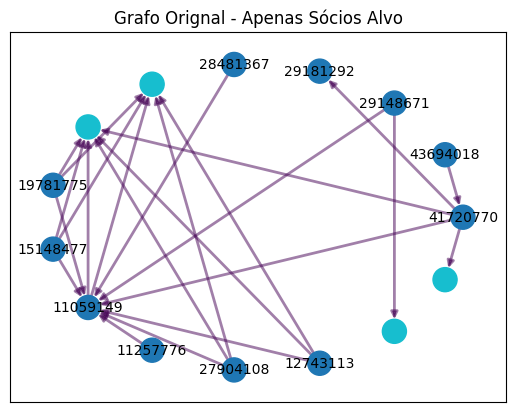

In [59]:
# Recupera lista de ids de sócios alvo
id_list = df_id_alvos['id'].tolist()
vertices, edges = get_vertices_edges_by_ids(g, id_list)
## Aciona ao edge o tipo de ligação 1-natural 2-sugerida
edges=edges.withColumn("id_tipoRel", lit(1))

pandas_vertices = vertices.toPandas()
pandas_edges = edges.toPandas()
plot_custom_graph(pandas_vertices, pandas_edges, title="Grafo Orignal - Apenas Sócios Alvo")

In [60]:
# Recupera lista de ids de sócios alvo
id_list = df_id_localizados['id'].tolist()
vertices, edges = get_vertices_edges_by_ids(g, id_list)
## Aciona ao edge o tipo de ligação 1-natural 2-sugerida
edges=edges.withColumn("id_tipoRel", lit(1))

pandas_vertices = vertices.toPandas()
pandas_edges = edges.toPandas()
pandas_edges = add_edges_from_df_sim(pandas_edges, df_sim)

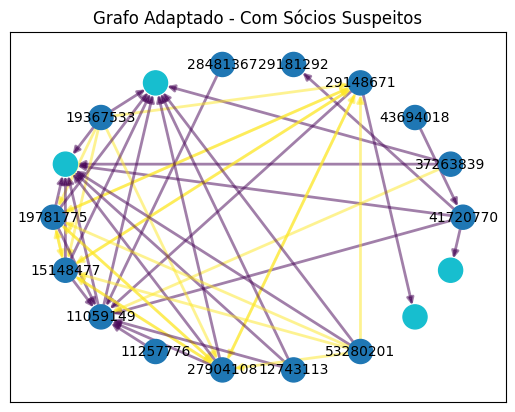

In [32]:
plot_custom_graph(pandas_vertices, pandas_edges, title="Grafo Adaptado - Com Sócios Suspeitos")

In [31]:
pandas_edges

,src,dst,te_dados_sc,id_tipoRel
0,15464658,00070363390120,"(000, 20130516, , 49, 2, 00000000000, 00)",1


In [32]:
pandas_vertices

,id,te_dados_em,id_estabelecimento,te_dados_es,id_tipoPessoa
0,15464658,"(05, 00000500000000, 70363390120, SANTA THEREZ...",000121,"(DF, 72701997, 61, 61, , FILHO.SENA10@GMAIL.CO...",1
1,00070363390120,None,None,None,2


In [33]:
spark.stop()